In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam, Adamax
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
# --- 1. Data Loading and Initial Shuffle ---
print("Loading and shuffling data...")
train_df = pd.read_csv("emnist_byclass_train.csv", header=None).astype('float32')
test_df = pd.read_csv("emnist_byclass_test.csv", header=None).astype('float32')
# Shuffle the dataframes
train_df = shuffle(train_df)
test_df = shuffle(test_df)

Loading and shuffling data...


In [4]:
# --- 2. Data Splitting and Normalization ---
print("Splitting and normalizing data...")
# Separate features (pixels) and labels
X_train_raw = train_df.iloc[:, 1:].values
y_train_raw = train_df.iloc[:, 0].values

X_test_raw = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values # Keep original test labels for final evaluation

# Normalize pixel values to be between 0 and 1
X_train_normalized = X_train_raw / 255.0
X_test_normalized = X_test_raw / 255.0

Splitting and normalizing data...


In [5]:
# --- 3. Efficient Image Transposition ---
# The EMNIST dataset is rotated and flipped; this corrects the orientation.
print("Correcting image orientation with efficient transposition...")

# Reshape the flat arrays into image formats (samples, height, width)
X_train_reshaped = X_train_normalized.reshape(X_train_normalized.shape[0], 28, 28)
X_test_reshaped = X_test_normalized.reshape(X_test_normalized.shape[0], 28, 28)

# Transpose the height and width axes for all images at once
# Axes are (0: samples, 1: height, 2: width). We swap 1 and 2.
X_train_transposed = np.transpose(X_train_reshaped, (0, 2, 1))
X_test_transposed = np.transpose(X_test_reshaped, (0, 2, 1))

Correcting image orientation with efficient transposition...


In [6]:
# --- 4. Train-Validation Split and Final Reshaping ---
# Create a proper validation set from the training data
print("Creating train-validation split...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_transposed, y_train_raw, test_size=0.2, random_state=42
)

# Reshape data for the CNN input layer (samples, height, width, channels)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)
X_test = X_test_transposed.reshape(X_test_transposed.shape[0], 28, 28, 1)

Creating train-validation split...


In [7]:
# --- 5. Label One-Hot Encoding ---
print("One-hot encoding labels...")
num_classes = 62
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

One-hot encoding labels...


Visualizing class distribution...


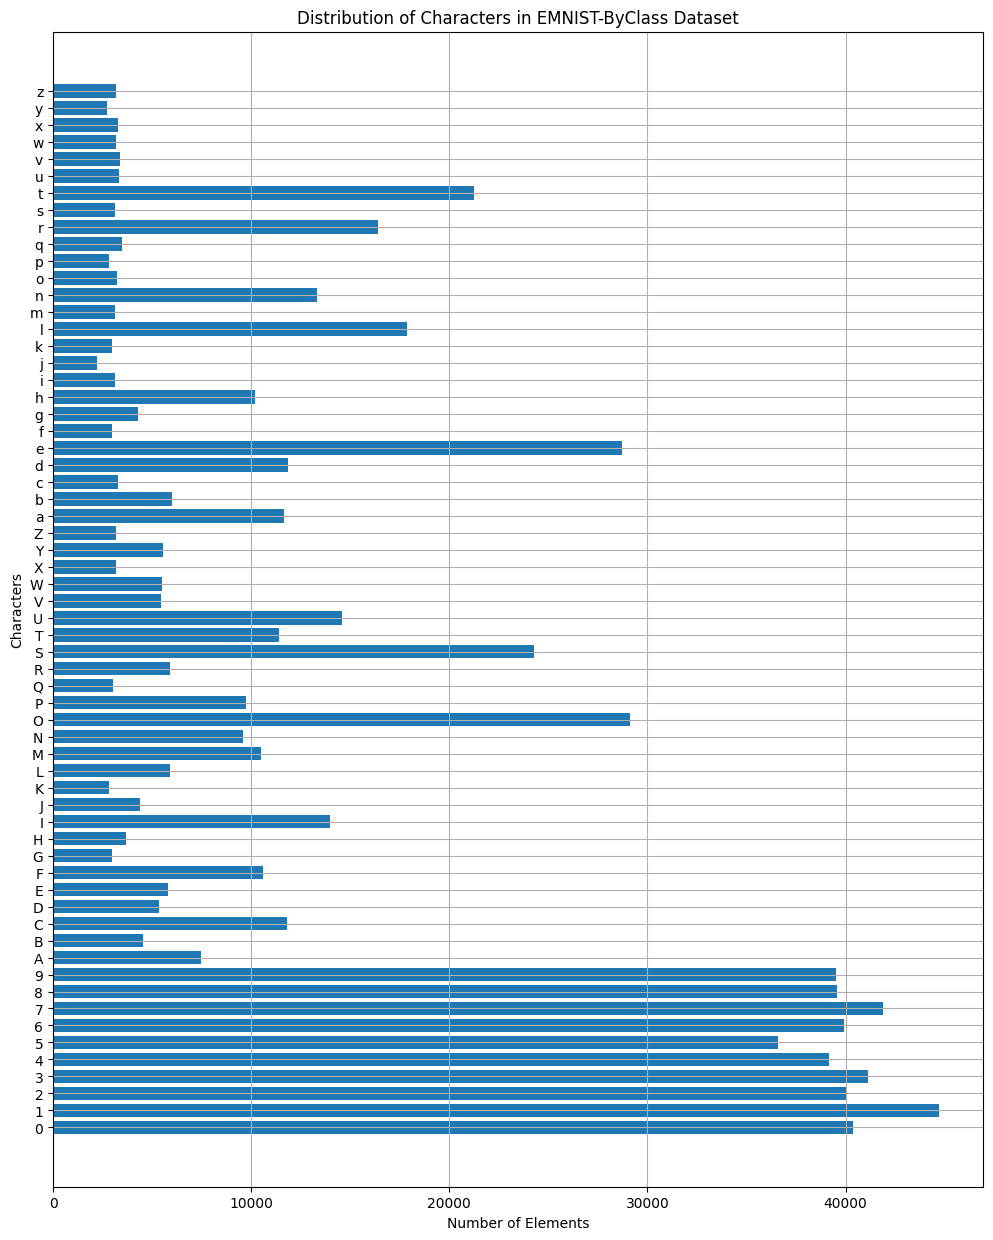

In [8]:
# --- 6. Character Mapping and Data Distribution Visualization ---
word_dict = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I',
    19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R',
    28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i',
    45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r',
    54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'
}
alphabets_digits = list(word_dict.values())

# Count distribution
print("Visualizing class distribution...")
all_labels = np.concatenate([y_train_raw, y_test])
count = np.zeros(num_classes, dtype='int')
for i in np.int_(all_labels):
    count[i] += 1

# Plotting the character distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 15))
ax.barh(alphabets_digits, count)
plt.xlabel("Number of Elements")
plt.ylabel("Characters")
plt.grid()
plt.title("Distribution of Characters in EMNIST-ByClass Dataset")
plt.show()

In [9]:
# --- 7. CNN Model Definition ---
print("Building the CNN model...")
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))

Building the CNN model...


e:\code practice\python\python_env2\az_hand\az_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# --- 8. Model Compilation and Training ---
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

print("\nStarting model training...")
history = model.fit(
    X_train, y_train_cat,
    epochs=15,  # Increased epochs for better learning
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stopping],
    verbose=1
)

# Save the trained model
model.save('HCR_English_updated.h5')
print("\nModel training complete and saved as HCR_English_updated.h5")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,075,518 (4.10 MB)

 Trainable params: 1,075,518 (4.10 MB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/15
17449/17449 ━━━━━━━━━━━━━━━━━━━━ 295s 17ms/step - accuracy: 0.7569 - loss: 0.7945 - val_accuracy: 0.8520 - val_loss: 0.4177
Epoch 2/15
17449/17449 ━━━━━━━━━━━━━━━━━━━━ 288s 16ms/step - accuracy: 0.8293 - loss: 0.5027 - val_accuracy: 0.8586 - val_loss: 0.3908
Epoch 3/15
17449/17449 ━━━━━━━━━━━━━━━━━━━━ 290s 17ms/step - accuracy: 0.8406 - loss: 0.4601 - val_accuracy: 0.8630 - val_loss: 0.3790
Epoch 4/15
17449/17449 ━━━━━━━━━━━━━━━━━━━━ 288s 17ms/step - accuracy: 0.8475 - loss: 0.4383 - val_accuracy: 0.8654 - val_loss: 0.3684
Epoch 5/15
17449/17449 ━━━━━━━━━━━━━━━━━━━━ 290s 17ms/step - accuracy: 0.8510 - loss: 0.4245 - val_accuracy: 0.8669 - val_loss: 0.3637
Epoch 6/15
17449/17449 ━━━━━━━━━━━━━━━━━━━━ 292s 17ms/step - accuracy: 0.8535 - loss: 0.4149 - val_accuracy: 0.8701 - val_loss: 0.3560
Epoch 7/15
17449/17449 ━━━━━━━━━━━━━━━━━━━━ 292s 17ms/step - accuracy: 0.8553 - loss: 0.4071 - val_accuracy: 0.8703 - val_loss: 0.3547
Epoch 8/15
17449/17449 ━━━━


Model training complete and saved as HCR_English_updated.h5


Visualizing model performance...


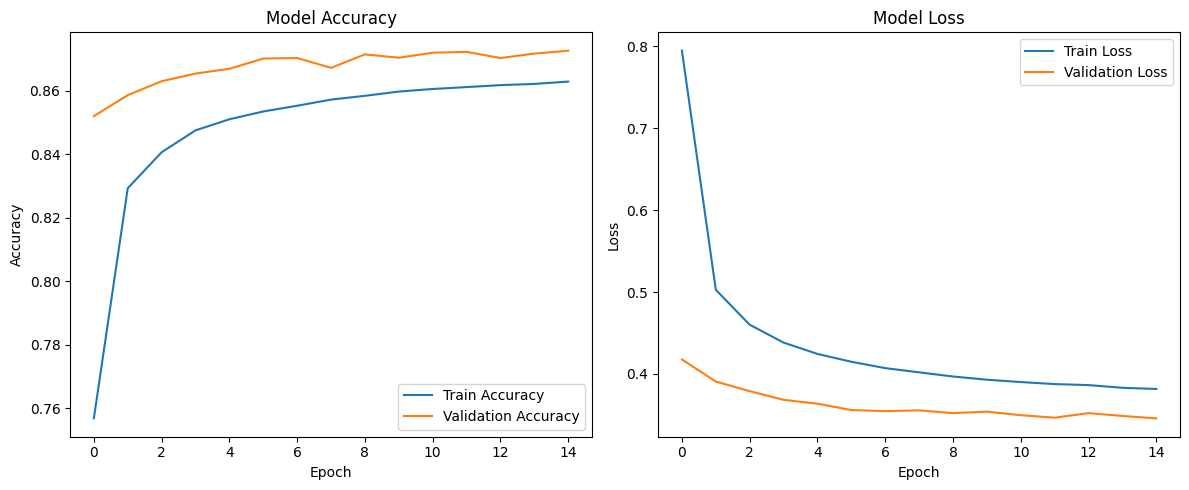

In [11]:
# --- 9. Performance Visualization ---
print("Visualizing model performance...")
fig = plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [12]:
# --- 10. Final Evaluation on Test Set ---
print("\nEvaluating model on the unseen test set...")
score = model.evaluate(X_test, y_test_cat, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')


Evaluating model on the unseen test set...
Test loss: 0.3458
Test accuracy: 0.8724



Visualizing predictions on test data...
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
Correctly classified images: 101477
Incorrectly classified images: 14846


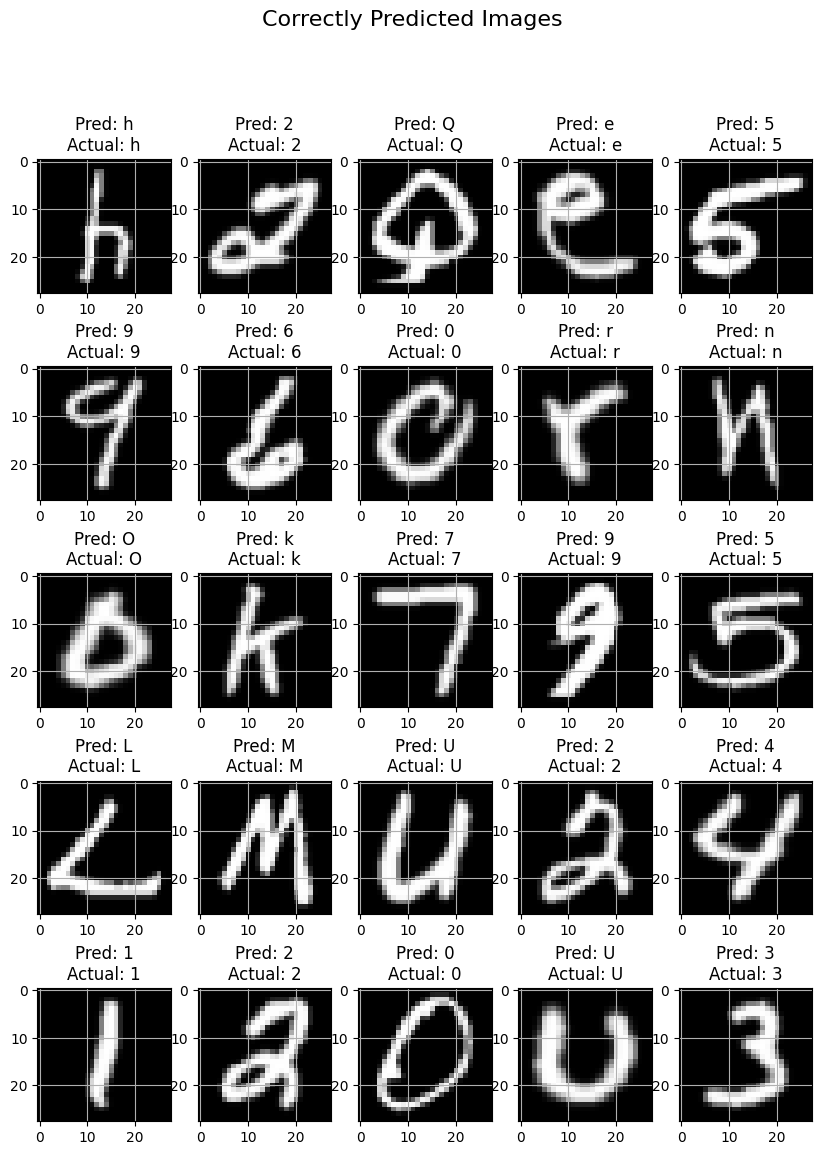

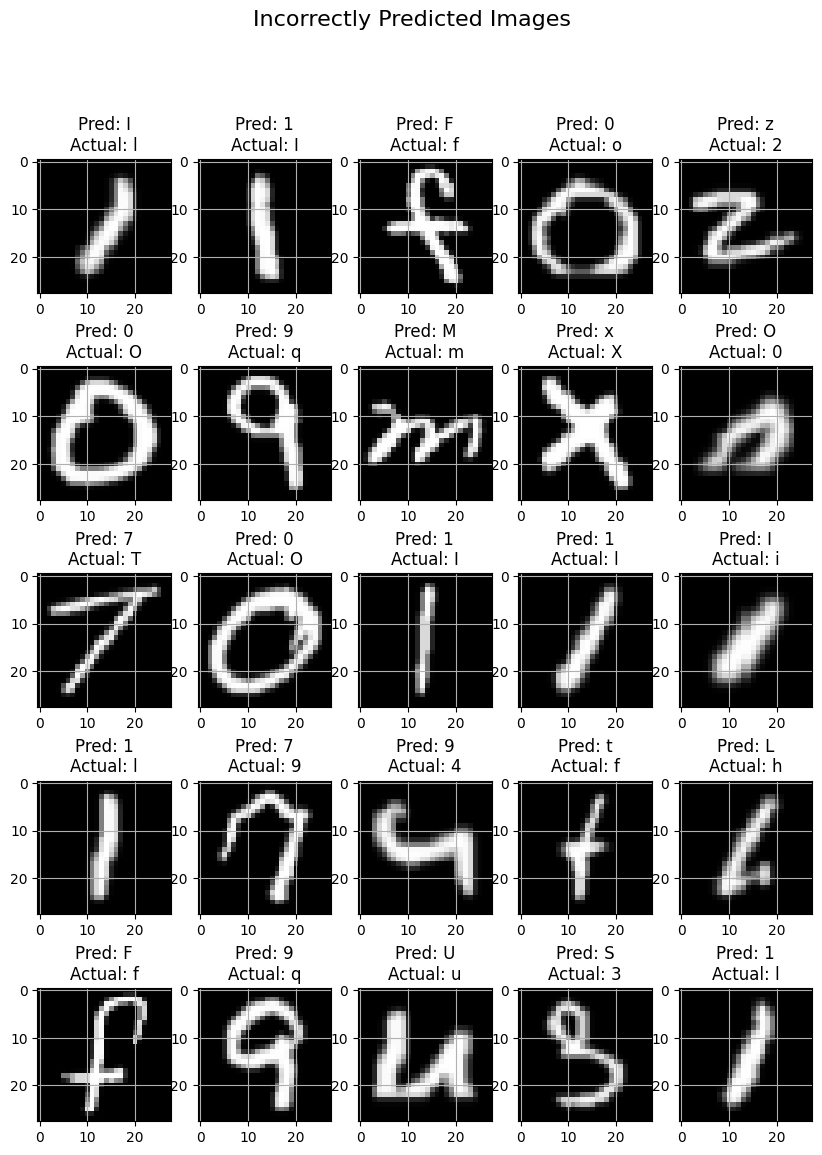

In [13]:
# --- 11. Prediction and Visualization on Test Data ---
print("\nVisualizing predictions on test data...")
predicted_classes = np.argmax(model.predict(X_test), axis=1)
y_test_int = np.int_(y_test)

correct_indices = np.nonzero(predicted_classes == y_test_int)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test_int)[0]

print(f"Correctly classified images: {len(correct_indices)}")
print(f"Incorrectly classified images: {len(incorrect_indices)}")

# Plot some correctly predicted images
fig, axes = plt.subplots(5, 5, figsize=(10, 13))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i >= len(correct_indices): break
    idx = correct_indices[i]
    img = np.reshape(X_test[idx], (28, 28))
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {word_dict[predicted_classes[idx]]}\nActual: {word_dict[y_test_int[idx]]}")
    ax.grid()
plt.suptitle("Correctly Predicted Images", fontsize=16)
plt.show()

# Plot some incorrectly predicted images
fig, axes = plt.subplots(5, 5, figsize=(10, 13))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i >= len(incorrect_indices): break
    idx = incorrect_indices[i]
    img = np.reshape(X_test[idx], (28, 28))
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {word_dict[predicted_classes[idx]]}\nActual: {word_dict[y_test_int[idx]]}")
    ax.grid()
plt.suptitle("Incorrectly Predicted Images", fontsize=16)
plt.show()


Processing and predicting on custom images...
Total custom images found: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


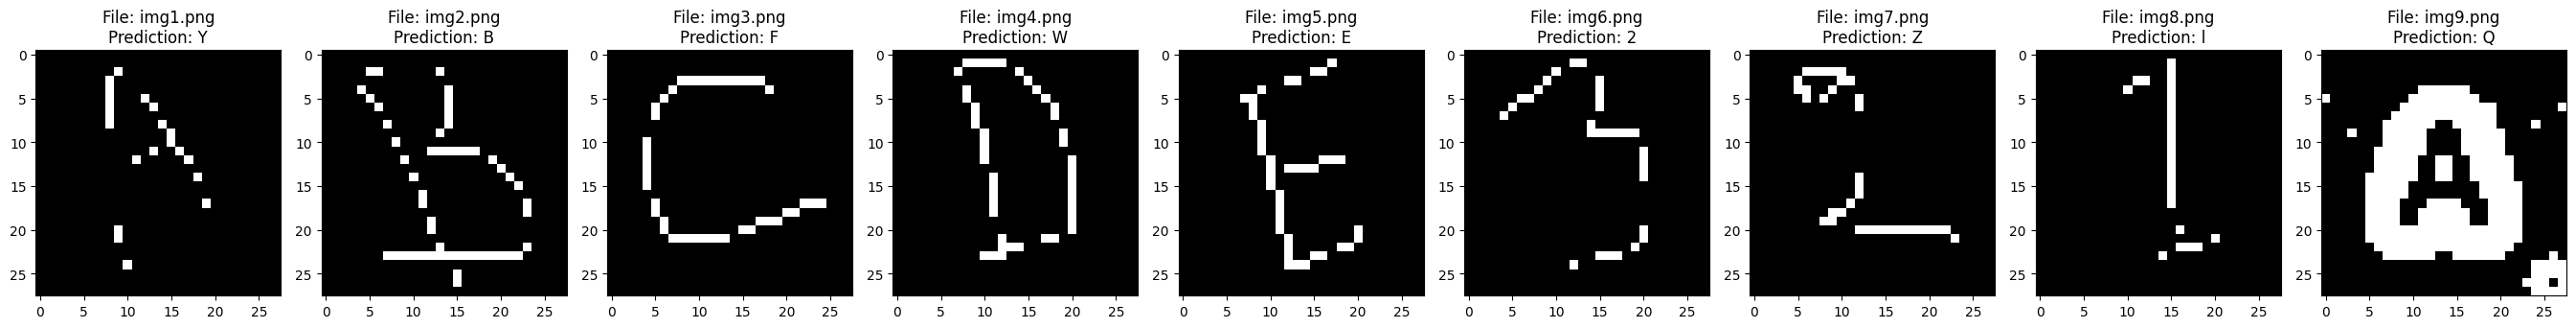

In [15]:
# --- 12. Prediction on Custom Images ---
# NOTE: Update 'my_dir' to the path of your custom image folder.
print("\nProcessing and predicting on custom images...")
my_dir = r"E:\code practice\python\python_env2\az_hand\own_english2" # <-- IMPORTANT: CHANGE THIS PATH
if not os.path.exists(my_dir):
    print(f"Directory not found: {my_dir}. Skipping custom image prediction.")
else:
    file_list = []
    own_data = []

    for root, dirs, files in os.walk(my_dir):
        for name in files:
            if name.lower().endswith(('.png', '.jpg', '.jpeg')):
                full_name = os.path.join(root, name)
                file_list.append(full_name)

    if not file_list:
        print("No images found in the specified directory.")
    else:
        for name in file_list:
            img_gray = cv2.imread(name, 0)
            img_gray = cv2.resize(img_gray, (28, 28))
            
            # Adaptive thresholding for better feature extraction
            img_binary = cv2.adaptiveThreshold(
                img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
            )
            
            # Invert the image (black background, white character)
            img_inverted = cv2.bitwise_not(img_binary)
            
            # Normalize and reshape for the model
            img_final = (img_inverted.astype('float32') / 255.0).reshape(1, 28, 28, 1)
            own_data.append((name, img_final, img_inverted))

        print(f"Total custom images found: {len(own_data)}")

        # Plot predictions for custom images
        num_images = len(own_data)
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 5))
        if num_images == 1: # Handle case of single image
            axes = [axes]
        axes = axes.flatten()

        for i, ax in enumerate(axes):
            name, img_data, display_img = own_data[i]
            ax.imshow(display_img, cmap='gray')
            
            pred = model.predict(img_data)
            ans = word_dict[np.argmax(pred)]
            ax.set_title(f"File: {os.path.basename(name)}\nPrediction: {ans}")
            ax.grid(False)
        plt.tight_layout()
        plt.show()